# Search for SN-like light curves in ZTF alerts

We will use lsdb package to load a Hats catalog with [ZTF](https://www.ztf.caltech.edu) alerts.
The dataset contains all alerts sent from the beginning of the survey until 2023-09-13 corresponding to objects having at least 20 detections.

The dataset is provided by the [ALeRCE](https://alerce.science) broker team.

The goal is to find supernova (SN) candidates in this dataset using the goodness of the Bazin ([Bazin+2009](https://doi.org/10.1051/0004-6361/200911847)) function fit – a simple parametric model for SN light curves.

The pipeline will be as follows:
1. Load the dataset with LSDB
2. Convert it to a nested format with `nested-dask` package
3. Fit Bazin function and extract some other light-curve features with `light-curve` package
4. Filter data and plot few light curves

### Install and import required packages

We need LSDB for data loading and analysis (includes [`dask`](https://dask.org), [`nested-pandas`](https://nested-pandas.readthedocs.org) and [`nested-dask`](https://nested-dask.readthedocs.org)) and [`light-curve`](https://github.com/light-curve/light-curve-python) package for feature extraction.

In [1]:
%pip install lsdb
# This --only-binary flag is required to avoid installation errors on some systems
%pip install --only-binary=light-curve light-curve


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import light_curve as licu
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client
from lsdb import read_hats

### Helper function for light-curve plotting

The function accepts a pandas data frame and plot a light curve.

In [3]:
def plot_lc(lc, nondet, title=None):
    """Plot light curve with non-detections."""
    for fid, band in zip([1, 2], "gr"):
        idx = lc["lc_fid"] == fid
        plt.scatter(lc["lc_mjd"][idx], lc["lc_magpsf"][idx], label=band, color=band, marker="x", s=10)
        plt.errorbar(lc["lc_mjd"][idx], lc["lc_magpsf"][idx], lc["lc_sigmapsf"][idx], color=band, ls="")

        idx = nondet["nondet_fid"] == fid
        plt.plot(nondet["nondet_mjd"][idx], nondet["nondet_diffmaglim"][idx], "v", color=band, alpha=0.25)

    plt.legend()
    plt.title(title)
    plt.xlabel("MJD")
    plt.ylabel("mag")
    plt.gca().invert_yaxis()

### Load catalog structure and "nest" columns

Here we load the catalog structure and transform list-columns to a compact representation.
These transformed columns are "nested data frames", so each item could be represented by a small pandas dataframe.
We are going to have three nested columns:

1. "lc", for light curves, each point corrersponds to some alert (detection)
2. "nondet", for non-detections (upper limits)
3. "ref", for ZTF reference objects associated with alerts

Here we do not download any data yet, all data access and analysis happens only after `.compute()` is called.

Here we display two versions of the catalog: the first one is the raw catalog with nested lists, and the second one is the catalog with nested columns.

In [6]:
ZTF_ALERTS = "https://data.lsdb.io/hats/alerce/"

# Load catalog with nested lists
raw_catalog = read_hats(
    ZTF_ALERTS,
)
display(raw_catalog)

# Pack all list-columns into single column
catalog_with_lc = raw_catalog.nest_lists(
    base_columns=[col for col in raw_catalog.columns if not col.startswith("lc_")],
    name="lc",
)

# Pack non-detections
catalog_with_nondet = catalog_with_lc.nest_lists(
    base_columns=[col for col in catalog_with_lc.columns if not col.startswith("nondet_")],
    name="nondet",
)

# Pack ZTF references
catalog = catalog_with_nondet.nest_lists(
    base_columns=[col for col in catalog_with_nondet.columns if not col.startswith("ref_")],
    name="ref",
)

catalog

,oid,mean_ra,mean_dec,lc_ra,lc_dec,lc_candid,lc_mjd,lc_fid,lc_pid,lc_diffmaglim,lc_isdiffpos,lc_nid,lc_magpsf,lc_sigmapsf,lc_magap,lc_sigmagap,lc_distnr,lc_rb,lc_rbversion,lc_drb,lc_drbversion,lc_magapbig,lc_sigmagapbig,lc_rfid,lc_magpsf_corr,lc_sigmapsf_corr,lc_sigmapsf_corr_ext,lc_corrected,lc_dubious,lc_parent_candid,lc_has_stamp,lc_step_id_corr,nondet_mjd,nondet_fid,nondet_diffmaglim,ref_rfid,ref_candid,ref_fid,ref_rcid,ref_field,ref_magnr,ref_sigmagnr,ref_chinr,ref_sharpnr,ref_ranr,ref_decnr,ref_mjdstartref,ref_mjdendref,ref_nframesref,Norder,Dir,Npix
npartitions=113,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,string[pyarrow],double[pyarrow],double[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: int64>[pyarrow],list<element: double>[pyarrow],list<element: int64>[pyarrow],list<element: int64>[pyarrow],list<element: double>[pyarrow],list<element: int64>[pyarrow],list<element: int64>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: string>[pyarrow],list<element: double>[pyarrow],list<element: string>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: bool>[pyarrow],list<element: bool>[pyarrow],list<element: double>[pyarrow],list<element: bool>[pyarrow],list<element: string>[pyarrow],list<element: double>[pyarrow],list<element: int64>[pyarrow],list<element: double>[pyarrow],list<element: int64>[pyarrow],list<element: int64>[pyarrow],list<element: int64>[pyarrow],list<element: int64>[pyarrow],list<element: int64>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: int64>[pyarrow],int8[pyarrow],int64[pyarrow],int64[pyarrow]
72057594037927936,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3170534137668829184,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3458764513820540928,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


,oid,mean_ra,mean_dec,Norder,Dir,Npix,lc,nondet,ref
npartitions=113,,,,,,,,,
0,string[pyarrow],double[pyarrow],double[pyarrow],int8[pyarrow],int64[pyarrow],int64[pyarrow],"nested<lc_ra: [list<element: double>], lc_dec:...","nested<nondet_mjd: [list<element: double>], no...","nested<ref_rfid: [list<element: int64>], ref_c..."
72057594037927936,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
3170534137668829184,...,...,...,...,...,...,...,...,...
3458764513820540928,...,...,...,...,...,...,...,...,...


### Plot example light curves

It is time to run our first `.compute()`!
Here we select the first catalog partition (e.g. a single catalog file), load it and plot first five light curves from this file.

Note how we use nested "lc" column here: each value is represented by a pandas light curve, which we use for plotting.

In [8]:
# "Compute" the first partition and plot few light curves

# Single partition would require single worker
with Client(n_workers=1) as client:
    display(client)
    ndf = catalog.partitions[0].compute()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 12,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60531,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:60536,Total threads: 12
Dashboard: http://127.0.0.1:60537/status,Memory: 32.00 GiB
Nanny: tcp://127.0.0.1:60534,


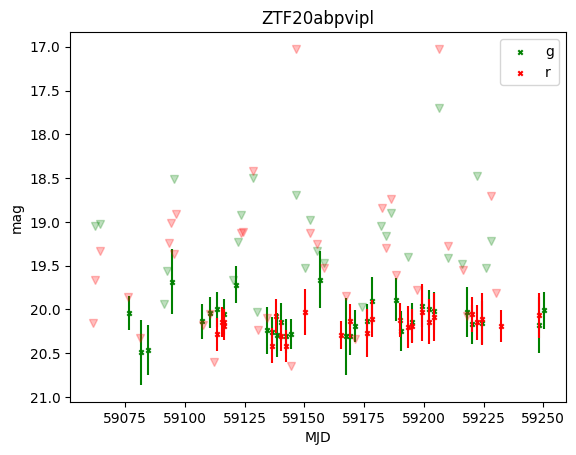

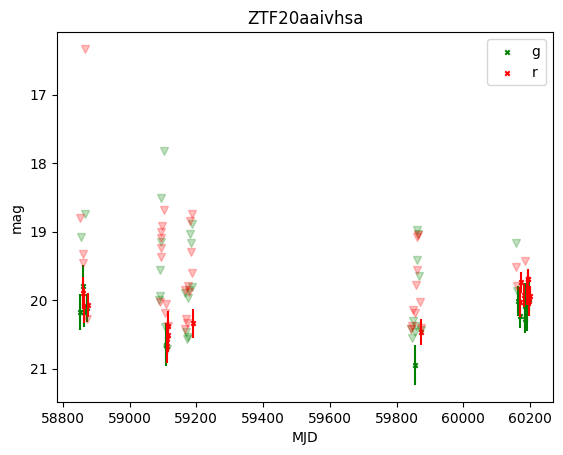

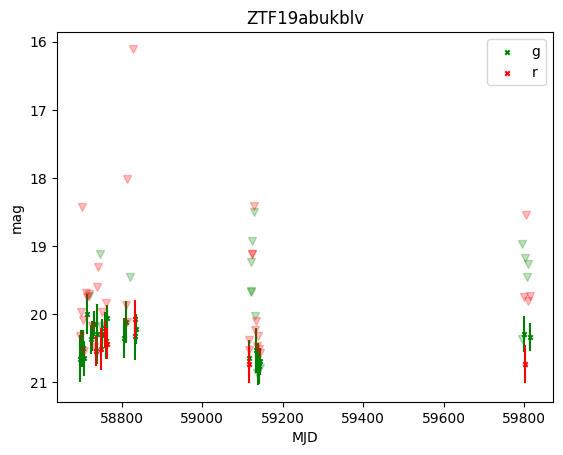

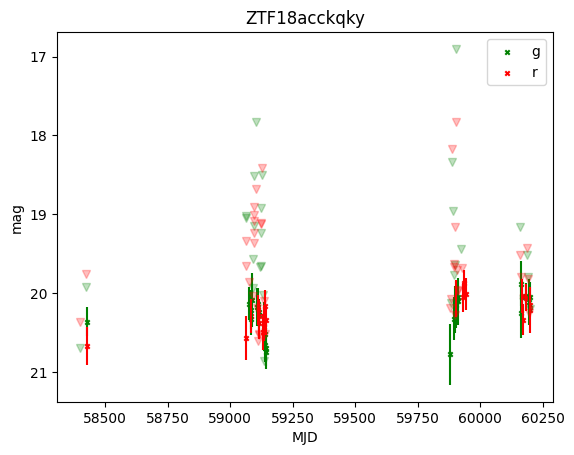

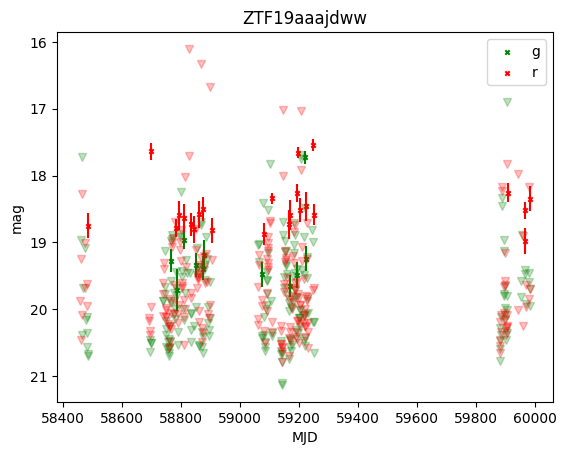

In [9]:
for i in range(5):
    lc = ndf["lc"].iloc[i]
    oid = ndf["oid"].iloc[i]
    nondet = ndf["nondet"].iloc[i]
    plt.figure()
    plot_lc(lc, nondet, title=str(oid))

### Extract features and filter

Here we use [`light-curve`](https://github.com/light-curve/light-curve-python) package to fit each r-band light-curve with Bazin function (Bazin+2009).

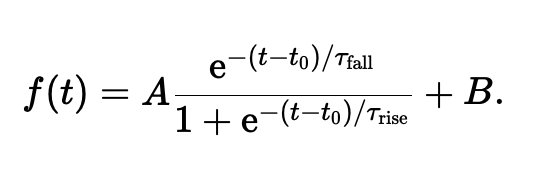

We also extract number of observations and reduced χ² of the fit with constant function to filter objects with low variability.

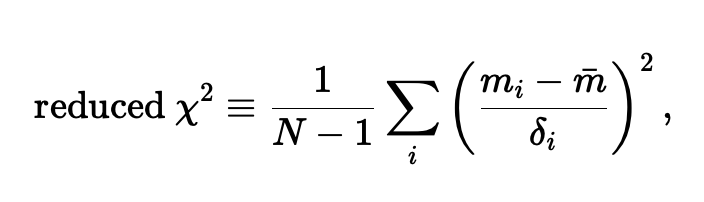

In [10]:
feature_extractor = licu.Extractor(
    licu.BazinFit(algorithm="ceres", ceres_niter=20, ceres_loss_reg=3),
    licu.ObservationCount(),
    licu.ReducedChi2(),
)


def extract_features(band, t, m, sigma, oid):
    # Select r-band only and remove observations with NaN errors
    valid_r = (band == 2) & np.isfinite(sigma)
    t, m, sigma = t[valid_r], m[valid_r], sigma[valid_r]

    # Sort time and remove duplicated, required by light-curve package
    _, idx = np.unique(t, return_index=True)
    t, m, sigma = t[idx], m[idx], sigma[idx]

    # Convert magnitude to fluxes
    flux = 10 ** (-0.4 * (m - 8.9))
    flux_err = 0.4 * np.log(10) * sigma * flux

    # Output NaN feature value if we cannot compute it,
    # e.g. we don't have enough r-band observations
    values = feature_extractor(t, flux, flux_err, fill_value=np.nan)
    return dict(zip(feature_extractor.names, values))


# Extract features, Catalog.reduce is still WIP, so we use underlying dataframe directly
# https://github.com/astronomy-commons/lsdb/pull/414
catalog_with_features = catalog.reduce(
    extract_features,  # function
    "lc.lc_fid",
    "lc.lc_mjd",
    "lc.lc_magpsf",
    "lc.lc_sigmapsf",
    "oid",  # columns to use
    meta=dict.fromkeys(feature_extractor.names, float),  # Dask meta
    append_columns=True,  # Add the result feature columns to the catalog
)

# Filter features to get nice light-curves
sn_candidates = catalog_with_features.query(
    "bazin_fit_reduced_chi2 > 0.8 and bazin_fit_reduced_chi2 < 3.0"
    " and bazin_fit_rise_time > 3 and bazin_fit_rise_time < 10"
    " and bazin_fit_fall_time < 30 and bazin_fit_fall_time > 10"
    " and observation_count >= 10"
    " and chi2 > 5.0"
)

sn_candidates

,oid,mean_ra,mean_dec,Norder,Dir,Npix,lc,nondet,ref,bazin_fit_amplitude,bazin_fit_baseline,bazin_fit_reference_time,bazin_fit_rise_time,bazin_fit_fall_time,bazin_fit_reduced_chi2,observation_count,chi2
npartitions=113,,,,,,,,,,,,,,,,,
0,string[pyarrow],double[pyarrow],double[pyarrow],int8[pyarrow],int64[pyarrow],int64[pyarrow],"nested<lc_ra: [list<element: double>], lc_dec:...","nested<nondet_mjd: [list<element: double>], no...","nested<ref_rfid: [list<element: int64>], ref_c...",float64,float64,float64,float64,float64,float64,float64,float64
72057594037927936,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3170534137668829184,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3458764513820540928,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Run analysis

Let's run our analysis over the whole catalog and output result to `nested-pandas` data frame object.
We run analysis in parallel here, using Dask.
Please consult the Dask documentation for cluster configuration.

It would download ~21GB of data - check your Internet connection speed and give it some time.
(You can also select a single partition as we did before, just prepand `.compute()` with `.partitions[0].compute()`.)

In [11]:
%%time

with Client(n_workers=3, memory_limit="10GB", threads_per_worker=2) as client:
    display(client)
    ndf = sn_candidates.compute()

ndf

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 6,Total memory: 27.94 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60581,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 27.94 GiB
Comm: tcp://127.0.0.1:60590,Total threads: 2
Dashboard: http://127.0.0.1:60595/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:60584,


CPU times: user 1min 52s, sys: 26.9 s, total: 2min 19s
Wall time: 33min 9s


,oid,mean_ra,mean_dec,Norder,Dir,Npix,lc,nondet,ref,bazin_fit_amplitude,bazin_fit_baseline,bazin_fit_reference_time,bazin_fit_rise_time,bazin_fit_fall_time,bazin_fit_reduced_chi2,observation_count,chi2
_healpix_29,,,,,,,,,,,,,,,,,
2405857242818793,ZTF20abwzqzo,41.513817,3.329906,1,0,0,lc_ra lc_dec lc_candid ...,nondet_mjd nondet_fid nondet_diffmagli...,ref_rfid ref_candid ref_fid re...,0.000408,0.000030,59100.573583,3.111346,11.490058,0.879535,28.0,56.120445
3203066719741431,ZTF22abmxzxm,42.60675,5.793783,1,0,0,lc_ra lc_dec lc_candid ...,nondet_mjd nondet_fid nondet_diffmagli...,ref_rfid ref_candid ref_fid re...,0.000363,0.000032,59870.560379,3.061167,20.848320,1.679472,13.0,36.492215
10935697778842557,ZTF21abvdazf,41.059097,10.256258,1,0,0,lc_ra lc_dec lc_candid ...,nondet_mjd nondet_fid nondet_diffmagli...,ref_rfid ref_candid ref_fid re...,0.000111,0.000005,59455.898052,5.144836,24.962658,1.132158,14.0,11.381434
15846987093732276,ZTF20acqlfwb,42.891443,13.021577,1,0,0,lc_ra lc_dec lc_candid ...,nondet_mjd nondet_fid nondet_diffmagli...,ref_rfid ref_candid ref_fid re...,0.000187,0.000003,59174.930188,3.182938,21.147838,0.898472,20.0,26.000655
29759010088767360,ZTF22abfyzir,48.358801,19.789209,1,0,0,lc_ra lc_dec lc_candid ...,nondet_mjd nondet_fid nondet_diffmagli...,ref_rfid ref_candid ref_fid re...,0.000369,0.000006,59844.007861,3.360073,23.618371,0.888075,44.0,72.378785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448044297436092099,ZTF22abbausm,318.621236,-9.047612,0,0,11,lc_ra lc_dec lc_candid ...,nondet_mjd nondet_fid nondet_diffmagli...,ref_rfid ref_candid ref_fid re...,0.000873,0.000007,59815.424716,3.664686,27.214244,1.646161,26.0,144.653164
3449086288422995259,ZTF22aaynpda,321.732295,-7.016983,0,0,11,lc_ra lc_dec lc_candid ...,nondet_mjd nondet_fid nondet_diffmagli...,ref_rfid ref_candid ref_fid re...,0.001689,0.000030,59805.238801,3.632095,25.991767,1.706844,31.0,306.649569
3449618307040430992,ZTF22abmcezf,319.982093,-6.437505,0,0,11,lc_ra lc_dec lc_candid ...,nondet_mjd nondet_fid nondet_diffmagli...,ref_rfid ref_candid ref_fid re...,0.000580,-0.000044,59866.010056,3.728221,28.085254,0.890226,17.0,46.556925


### Plot SN candidate light curves

Let's plot light curves of our objects and compare them to what we had before.

https://alerce.online/object/ZTF20abwzqzo
https://alerce.online/object/ZTF22abmxzxm
https://alerce.online/object/ZTF21abvdazf
https://alerce.online/object/ZTF20acqlfwb
https://alerce.online/object/ZTF22abfyzir


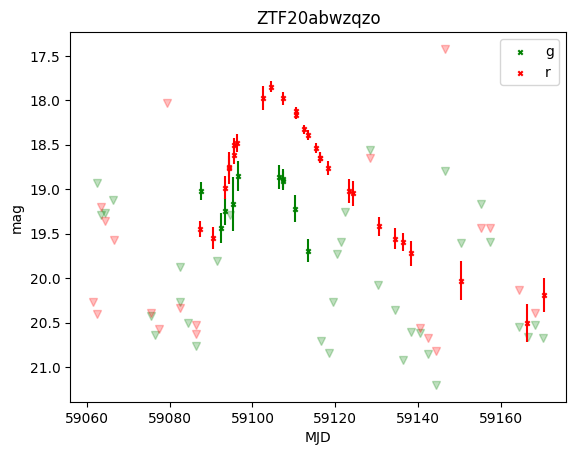

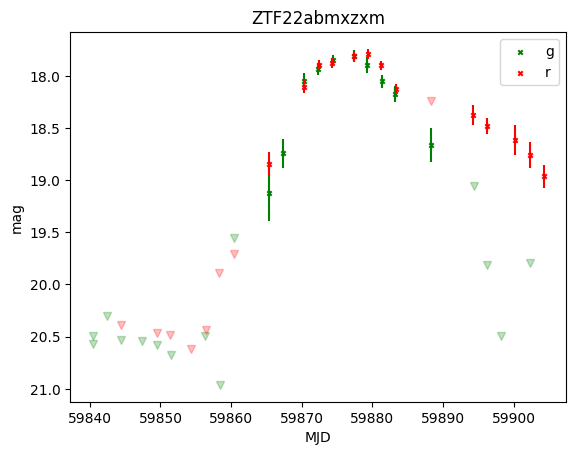

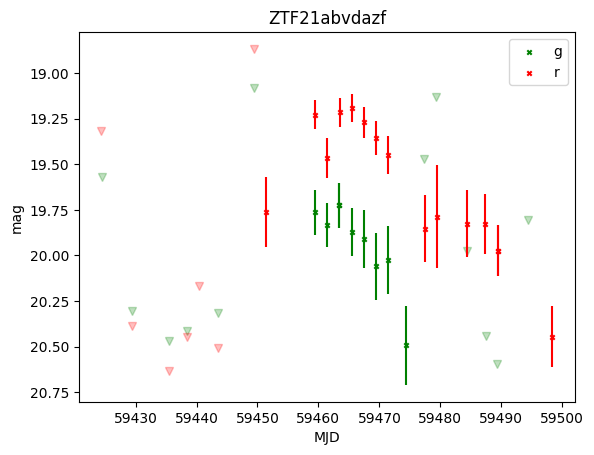

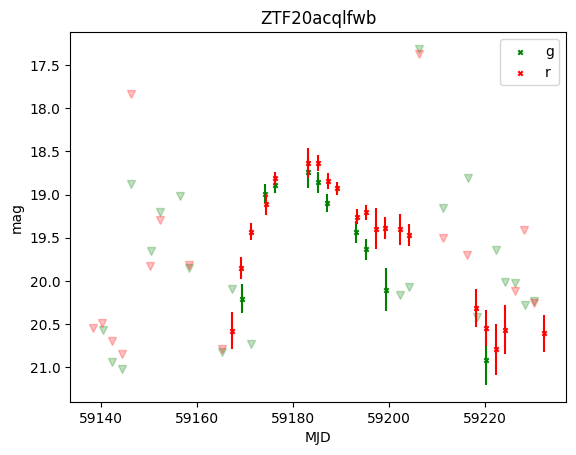

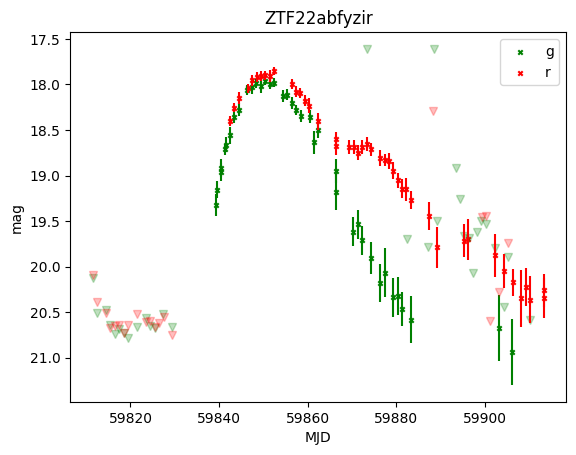

In [12]:
head = ndf.head(5)

for oid, lc, nondet in head[["oid", "lc", "nondet"]].itertuples(index=False):
    plt.figure()
    plot_lc(lc, nondet, title=oid)
    print(f"https://alerce.online/object/{oid}")